# Air Quality Prediction - Complete Analysis

Dataset ini berisi data kualitas udara dengan berbagai parameter:
- **CO(GT)**: Carbon Monoxide
- **PT08.S1(CO)**: Sensor CO
- **NMHC(GT)**: Non-Methanic Hydrocarbons
- **C6H6(GT)**: Benzene
- **PT08.S2(NMHH)**: Sensor NMHC
- **NOx(GT)**: Nitrogen Oxides
- **PT08.S3(NO2)**: Sensor NO2
- **NO2(GT)**: Nitrogen Dioxide
- **PT08.S4(NO2)**: Sensor NO2 (kedua)
- **PT08.S5(O3)**: Sensor O3
- **T**: Temperature
- **RH**: Relative Humidity
- **AH**: Absolute Humidity
- **AQI_TOTAL**: Air Quality Index (TARGET)

Tujuan: Memprediksi AQI_TOTAL menggunakan berbagai model ML


## 1. Import Libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## 2. Load and Explore Data

In [29]:
# Load data
df = pd.read_excel('/content/sample_data/AirQualityUCI_with_AQI_total.xlsx')

print("Dataset Shape:", df.shape)
print("\n" + "="*80)
print("First 5 Rows:")
print(df.head())

print("\n" + "="*80)
print("Dataset Info:")
print(df.info())

print("\n" + "="*80)
print("Statistical Summary:")
print(df.describe())

print("\n" + "="*80)
print("Missing Values:")
print(df.isnull().sum())

Dataset Shape: (9357, 19)

First 5 Rows:
        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10  19:00:00     2.0      1292.25       112   9.397165   
2 2004-03-10  20:00:00     2.2      1402.00        88   8.997817   
3 2004-03-10  21:00:00     2.2      1375.50        80   9.228796   
4 2004-03-10  22:00:00     1.6      1272.25        51   6.518224   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   
2         939.25    131.0       1140.00    114.0       1554.50      1074.00   
3         948.25    172.0       1092.00    122.0       1583.75      1203.25   
4         835.50    131.0       1205.00    116.0       1490.00      1110.00   

       T         RH        AH     AQI_CO     AQI_NO2  AQI_O3   AQI_total  


## 3. Data Preprocessing

In [30]:
# Combine Date and Time columns if they exist
if 'Date' in df.columns and 'Time' in df.columns:
    # Convert to string first, then combine
    df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')
    df.drop(['Date', 'Time'], axis=1, inplace=True)
    df.set_index('Datetime', inplace=True)
    print(f"Datetime index created. Range: {df.index.min()} to {df.index.max()}")
# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Handle missing values
print(f"Missing values before: {df[numeric_cols].isnull().sum().sum()}")
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
print(f"Missing values after: {df[numeric_cols].isnull().sum().sum()}")

# Remove outliers using IQR method
def remove_outliers(data, columns, threshold=3):
    df_clean = data.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - threshold * IQR
        upper = Q3 + threshold * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

df_clean = remove_outliers(df, numeric_cols)
print(f"\nDataset shape after outlier removal: {df_clean.shape}")


Datetime index created. Range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Missing values before: 13682
Missing values after: 0

Dataset shape after outlier removal: (5929, 17)


## 4. Exploratory Data Analysis

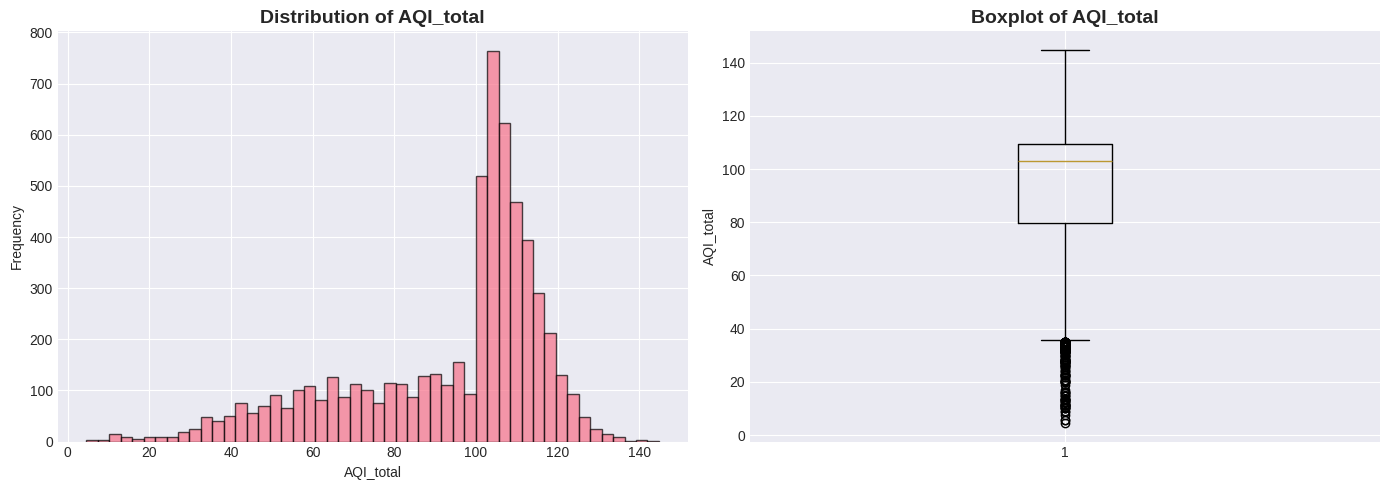

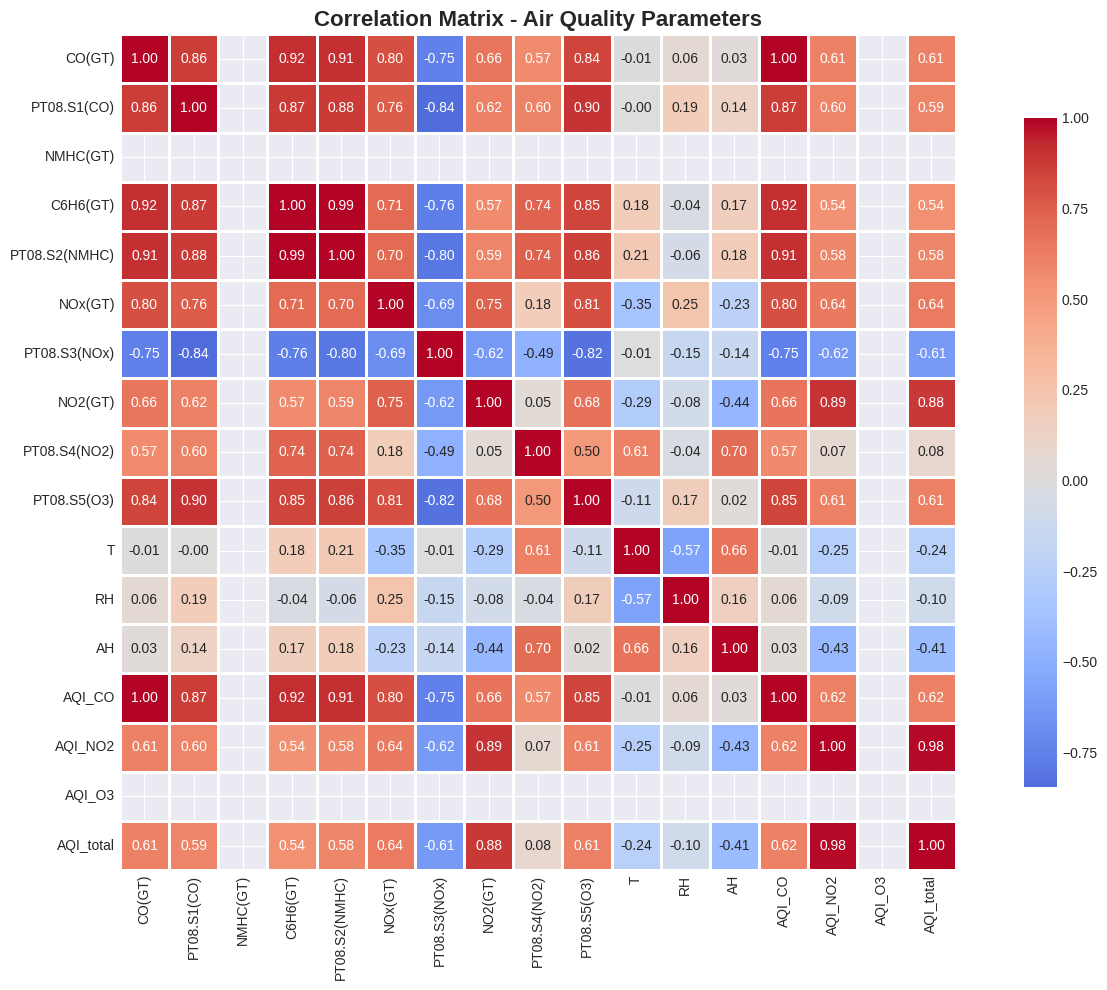


Top Correlations with AQI_total:
AQI_total        1.000000
AQI_NO2          0.978596
NO2(GT)          0.883378
NOx(GT)          0.637798
AQI_CO           0.615744
PT08.S5(O3)      0.612907
CO(GT)           0.610799
PT08.S1(CO)      0.593498
PT08.S2(NMHC)    0.583017
C6H6(GT)         0.540724
PT08.S4(NO2)     0.079348
RH              -0.098612
T               -0.241078
AH              -0.412126
PT08.S3(NOx)    -0.614529
NMHC(GT)              NaN
AQI_O3                NaN
Name: AQI_total, dtype: float64


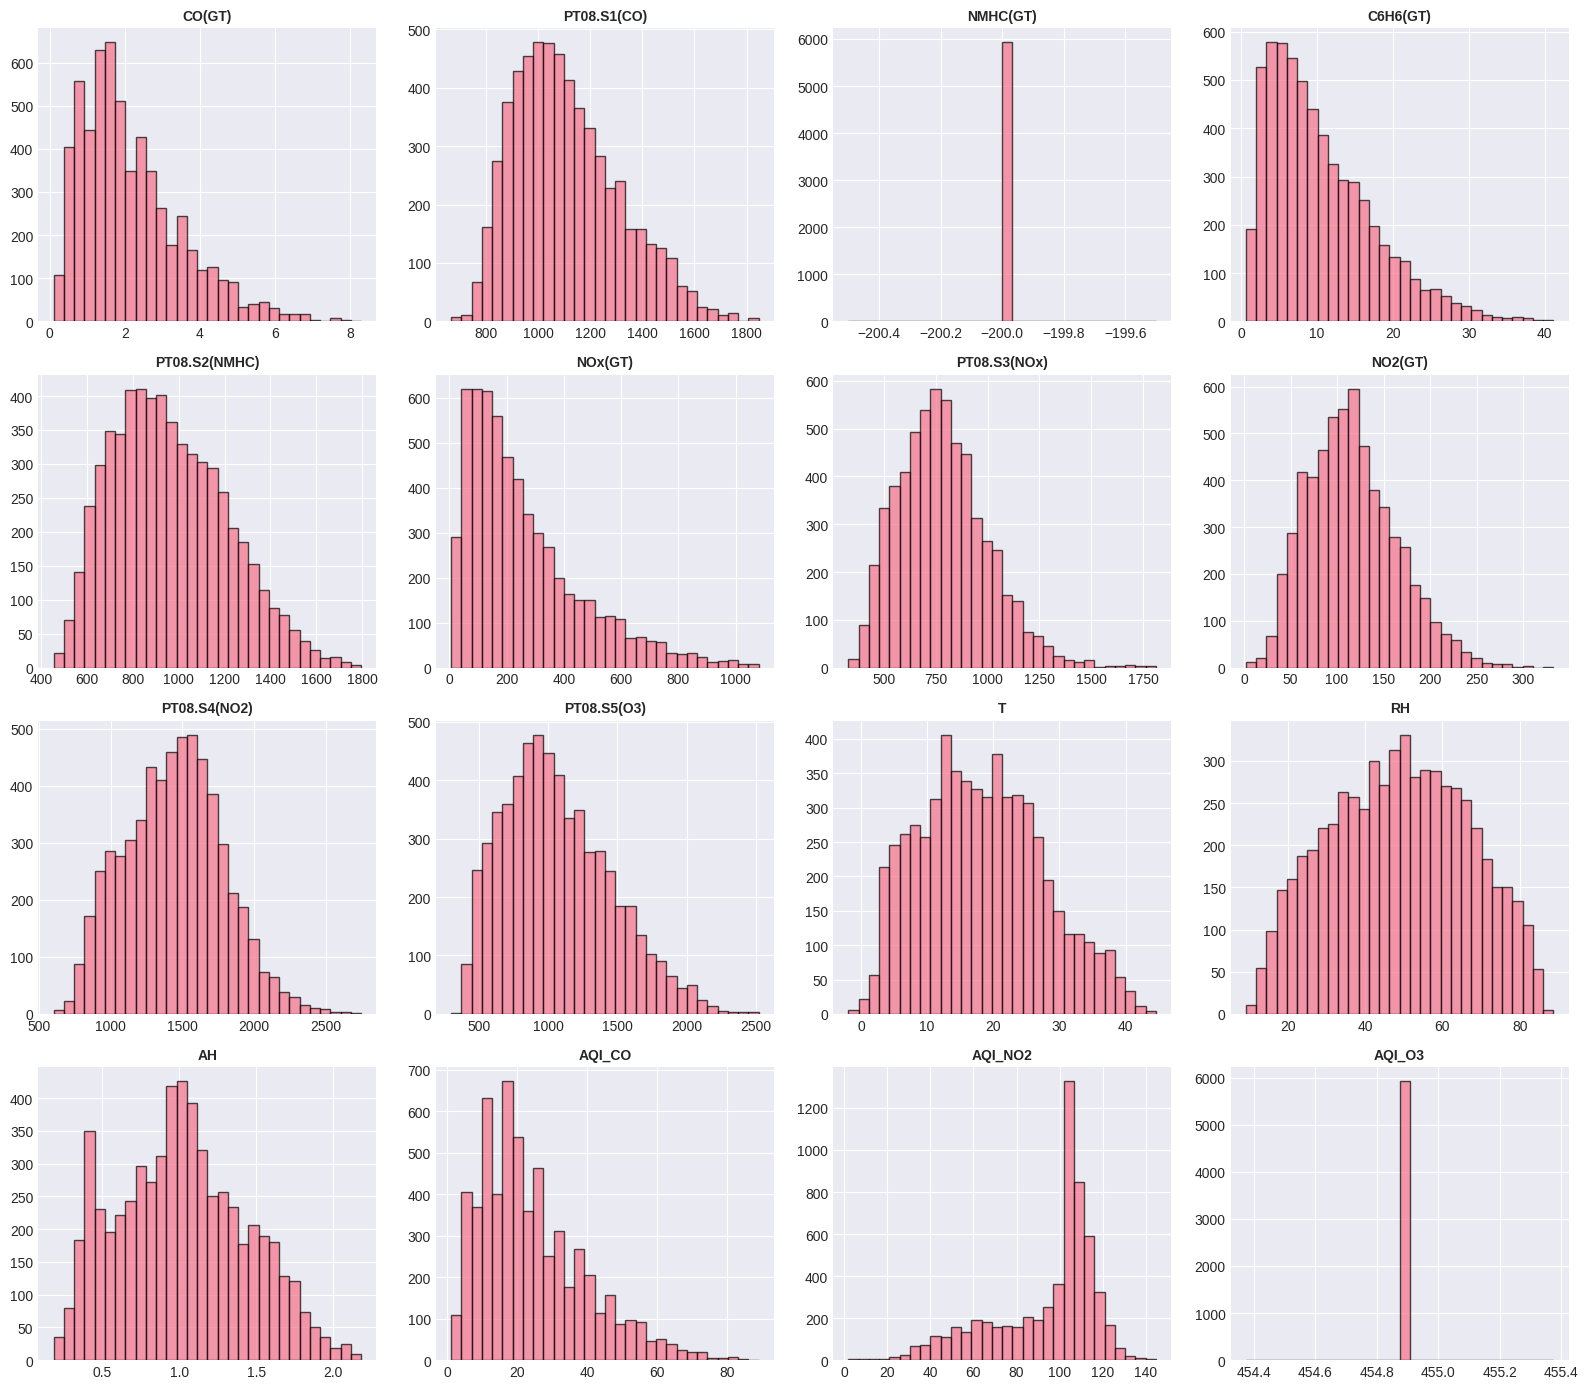

In [31]:
# Distribution of target variable
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_clean['AQI_total'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of AQI_total', fontsize=14, fontweight='bold')
axes[0].set_xlabel('AQI_total')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(df_clean['AQI_total'])
axes[1].set_title('Boxplot of AQI_total', fontsize=14, fontweight='bold')
axes[1].set_ylabel('AQI_total')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(14, 10))
correlation = df_clean[numeric_cols].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Air Quality Parameters', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Top correlations with target
target_corr = correlation['AQI_total'].sort_values(ascending=False)
print("\nTop Correlations with AQI_total:")
print(target_corr)

# Feature distributions
fig, axes = plt.subplots(4, 4, figsize=(16, 14))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols[:16]):
    axes[idx].hist(df_clean[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(col, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('')

plt.tight_layout()
plt.show()


## 5. Feature Engineering

In [32]:
# Create time-based features if datetime index exists
if isinstance(df_clean.index, pd.DatetimeIndex):
    df_clean['hour'] = df_clean.index.hour
    df_clean['day_of_week'] = df_clean.index.dayofweek
    df_clean['month'] = df_clean.index.month

    # Cyclical encoding for hour
    df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
    df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

    print("Time-based features created")

Time-based features created


## 6. Prepare Data for Modeling

In [33]:
# Define features and target
target = 'AQI_total'
features = [col for col in df_clean.columns if col != target]

X = df_clean[features]
y = df_clean[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Features shape: (5929, 21)
Target shape: (5929,)

Training set: (4743, 21)
Test set: (1186, 21)


## 7. Baseline Models Comparison


Training and evaluating baseline models...

Training Linear Regression...
  Train R²: 0.9554
  Test R²: 0.9736
  Test RMSE: 3.8560
  Test MAE: 0.9099
  CV R² Mean: 0.9555 (+/- 0.0186)

Training Ridge...
  Train R²: 0.9554
  Test R²: 0.9736
  Test RMSE: 3.8564
  Test MAE: 0.9135
  CV R² Mean: 0.9555 (+/- 0.0186)

Training Lasso...
  Train R²: 0.9527
  Test R²: 0.9719
  Test RMSE: 3.9815
  Test MAE: 1.2265
  CV R² Mean: 0.9531 (+/- 0.0191)

Training ElasticNet...
  Train R²: 0.8782
  Test R²: 0.8913
  Test RMSE: 7.8268
  Test MAE: 5.8377
  CV R² Mean: 0.8781 (+/- 0.0142)

Training Decision Tree...
  Train R²: 1.0000
  Test R²: 0.9996
  Test RMSE: 0.4753
  Test MAE: 0.0368
  CV R² Mean: 0.9958 (+/- 0.0049)

Training Random Forest...
  Train R²: 0.9998
  Test R²: 0.9996
  Test RMSE: 0.4567
  Test MAE: 0.0356
  CV R² Mean: 0.9984 (+/- 0.0014)

Training Gradient Boosting...
  Train R²: 0.9998
  Test R²: 0.9995
  Test RMSE: 0.5404
  Test MAE: 0.2020
  CV R² Mean: 0.9993 (+/- 0.0005)

Trainin

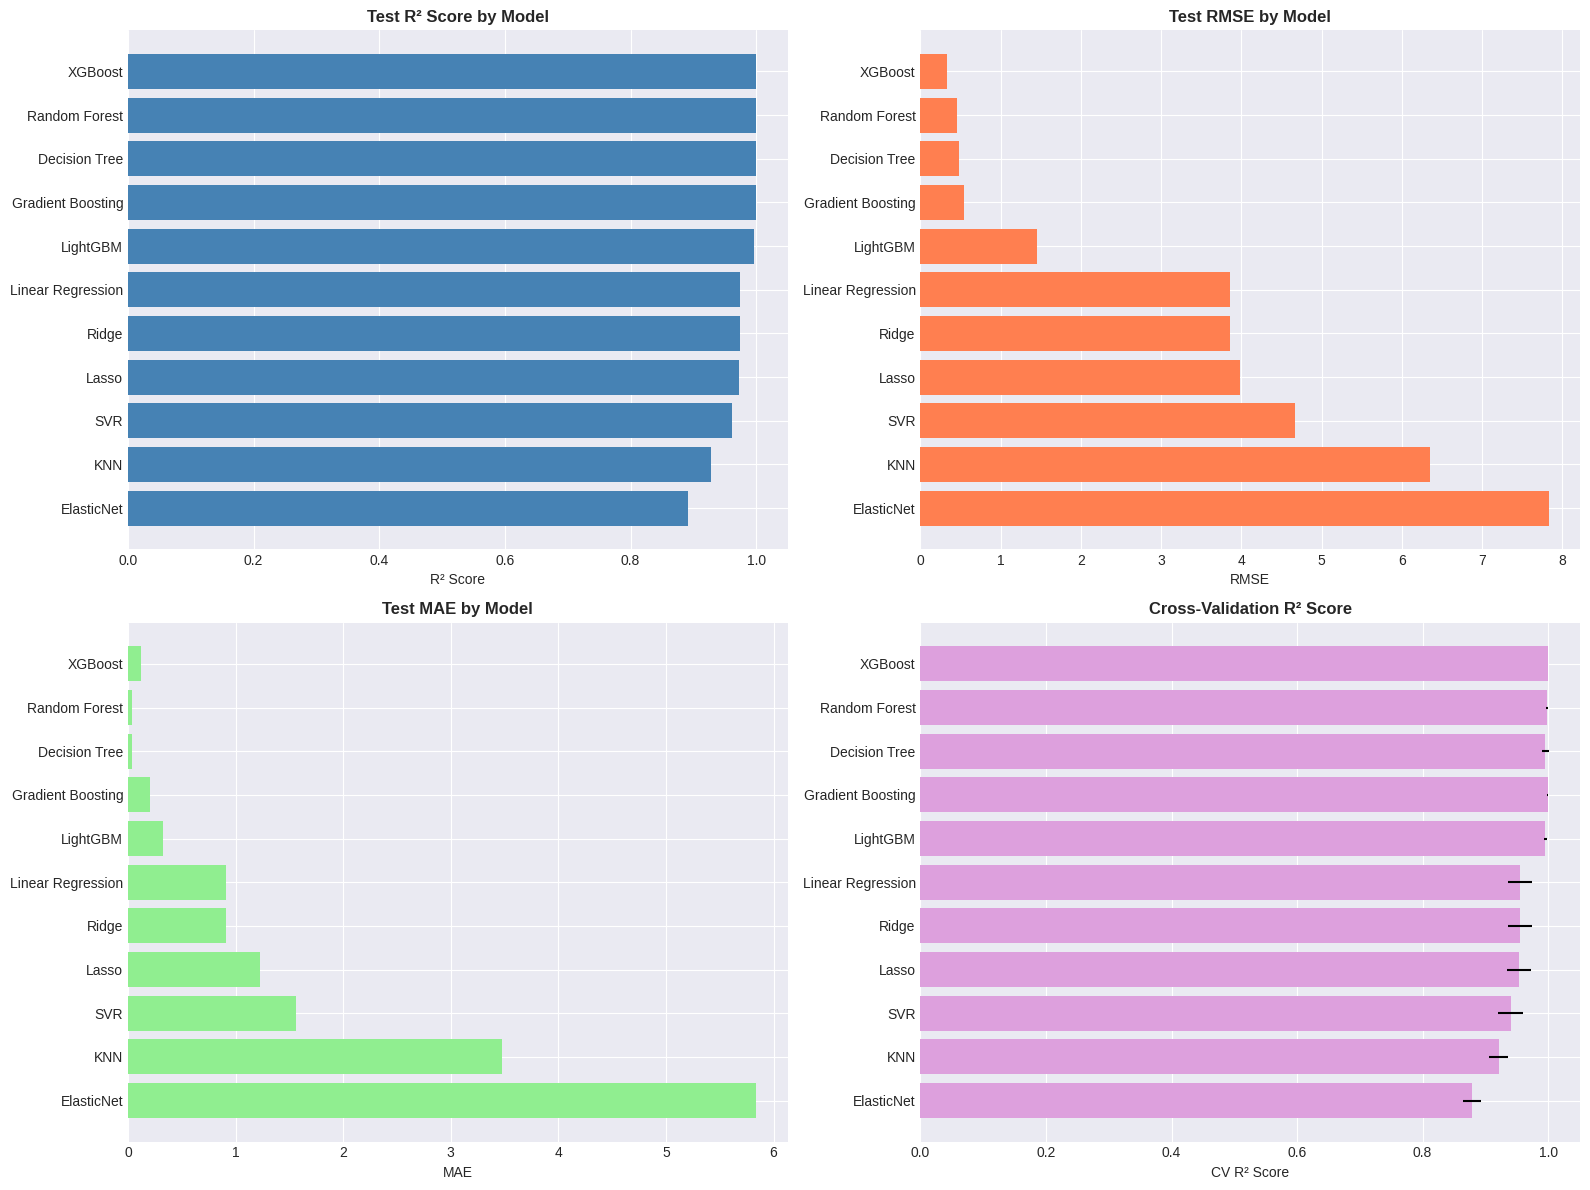

In [34]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

# Train and evaluate all models
results = []

print("\nTraining and evaluating baseline models...")
print("="*100)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for distance-based models
    if name in ['SVR', 'KNN', 'Ridge', 'Lasso', 'ElasticNet']:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test

    # Train
    model.fit(X_tr, y_train)

    # Predict
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)

    # Evaluate
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)

    # Cross-validation
    cv_scores = cross_val_score(model, X_tr, y_train, cv=5,
                                scoring='r2', n_jobs=-1)

    results.append({
        'Model': name,
        'Train R2': train_r2,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MAE': test_mae,
        'CV R2 Mean': cv_scores.mean(),
        'CV R2 Std': cv_scores.std()
    })

    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE: {test_mae:.4f}")
    print(f"  CV R² Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test R2', ascending=False)

print("\n" + "="*100)
print("BASELINE MODELS COMPARISON:")
print(results_df.to_string(index=False))

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R2 Score
axes[0, 0].barh(results_df['Model'], results_df['Test R2'], color='steelblue')
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Test R² Score by Model', fontweight='bold')
axes[0, 0].invert_yaxis()

# RMSE
axes[0, 1].barh(results_df['Model'], results_df['Test RMSE'], color='coral')
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_title('Test RMSE by Model', fontweight='bold')
axes[0, 1].invert_yaxis()

# MAE
axes[1, 0].barh(results_df['Model'], results_df['Test MAE'], color='lightgreen')
axes[1, 0].set_xlabel('MAE')
axes[1, 0].set_title('Test MAE by Model', fontweight='bold')
axes[1, 0].invert_yaxis()

# CV Scores
axes[1, 1].barh(results_df['Model'], results_df['CV R2 Mean'],
                xerr=results_df['CV R2 Std'], color='plum')
axes[1, 1].set_xlabel('CV R² Score')
axes[1, 1].set_title('Cross-Validation R² Score', fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()


## 8. Hyperparameter Tuning - Top 3 Models

In [35]:
# Select top 3 models
top_models = results_df.head(3)['Model'].tolist()
print(f"\nTuning top 3 models: {top_models}")

tuned_results = []


Tuning top 3 models: ['XGBoost', 'Random Forest', 'Decision Tree']


### 8.1 Random Forest Hyperparameter Tuning

In [36]:
if 'Random Forest' in top_models:
    print("\n" + "="*80)
    print("TUNING RANDOM FOREST...")

    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
    rf_grid = RandomizedSearchCV(
        rf_model, rf_param_grid, n_iter=50, cv=5,
        scoring='r2', n_jobs=-1, random_state=42, verbose=1
    )

    rf_grid.fit(X_train, y_train)

    print(f"\nBest parameters: {rf_grid.best_params_}")
    print(f"Best CV R²: {rf_grid.best_score_:.4f}")

    # Evaluate
    y_pred_test = rf_grid.predict(X_test)
    tuned_results.append({
        'Model': 'Random Forest (Tuned)',
        'Test R2': r2_score(y_test, y_pred_test),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Best Params': str(rf_grid.best_params_)
    })


TUNING RANDOM FOREST...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30}
Best CV R²: 0.9986


### 8.2 XGBoost Hyperparameter Tuning

In [37]:
if 'XGBoost' in top_models:
    print("\n" + "="*80)
    print("TUNING XGBOOST...")

    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5]
    }

    xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
    xgb_grid = RandomizedSearchCV(
        xgb_model, xgb_param_grid, n_iter=50, cv=5,
        scoring='r2', n_jobs=-1, random_state=42, verbose=1
    )

    xgb_grid.fit(X_train, y_train)

    print(f"\nBest parameters: {xgb_grid.best_params_}")
    print(f"Best CV R²: {xgb_grid.best_score_:.4f}")

    # Evaluate
    y_pred_test = xgb_grid.predict(X_test)
    tuned_results.append({
        'Model': 'XGBoost (Tuned)',
        'Test R2': r2_score(y_test, y_pred_test),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Best Params': str(xgb_grid.best_params_)
    })



TUNING XGBOOST...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Best CV R²: 0.9997


### 8.3 LightGBM Hyperparameter Tuning

In [38]:
if 'LightGBM' in top_models:
    print("\n" + "="*80)
    print("TUNING LIGHTGBM...")

    lgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, -1],
        'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'num_leaves': [31, 50, 70, 100],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }

    lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
    lgb_grid = RandomizedSearchCV(
        lgb_model, lgb_param_grid, n_iter=50, cv=5,
        scoring='r2', n_jobs=-1, random_state=42, verbose=1
    )

    lgb_grid.fit(X_train, y_train)

    print(f"\nBest parameters: {lgb_grid.best_params_}")
    print(f"Best CV R²: {lgb_grid.best_score_:.4f}")

    # Evaluate
    y_pred_test = lgb_grid.predict(X_test)
    tuned_results.append({
        'Model': 'LightGBM (Tuned)',
        'Test R2': r2_score(y_test, y_pred_test),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Best Params': str(lgb_grid.best_params_)
    })

### 8.4 Gradient Boosting Hyperparameter Tuning

In [39]:
if 'Gradient Boosting' in top_models:
    print("\n" + "="*80)
    print("TUNING GRADIENT BOOSTING...")

    gb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    gb_model = GradientBoostingRegressor(random_state=42)
    gb_grid = RandomizedSearchCV(
        gb_model, gb_param_grid, n_iter=50, cv=5,
        scoring='r2', n_jobs=-1, random_state=42, verbose=1
    )

    gb_grid.fit(X_train, y_train)

    print(f"\nBest parameters: {gb_grid.best_params_}")
    print(f"Best CV R²: {gb_grid.best_score_:.4f}")

    # Evaluate
    y_pred_test = gb_grid.predict(X_test)
    tuned_results.append({
        'Model': 'Gradient Boosting (Tuned)',
        'Test R2': r2_score(y_test, y_pred_test),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Best Params': str(gb_grid.best_params_)
    })

## 9. Final Results Comparison


TUNED MODELS COMPARISON:
                Model  Test R2  Test RMSE  Test MAE
      XGBoost (Tuned) 0.999823   0.315687  0.103226
Random Forest (Tuned) 0.999626   0.458982  0.037273

BEST HYPERPARAMETERS:

XGBoost (Tuned):
  {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'colsample_bytree': 1.0}

Random Forest (Tuned):
  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30}


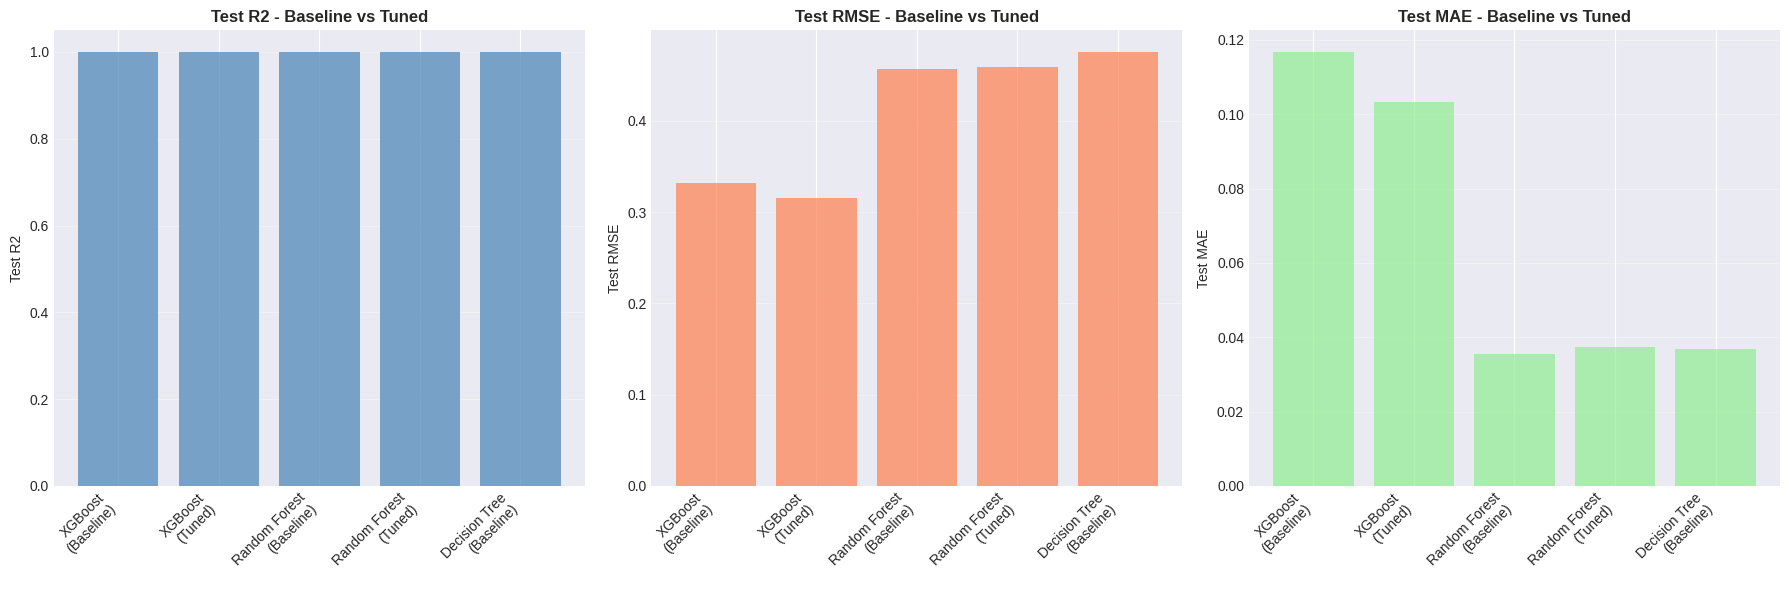

In [40]:
tuned_results_df = pd.DataFrame(tuned_results)
tuned_results_df = tuned_results_df.sort_values('Test R2', ascending=False)

print("\n" + "="*100)
print("TUNED MODELS COMPARISON:")
print(tuned_results_df[['Model', 'Test R2', 'Test RMSE', 'Test MAE']].to_string(index=False))

print("\n" + "="*100)
print("BEST HYPERPARAMETERS:")
for _, row in tuned_results_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  {row['Best Params']}")

# Compare baseline vs tuned
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ['Test R2', 'Test RMSE', 'Test MAE']
colors = ['steelblue', 'coral', 'lightgreen']

for idx, metric in enumerate(metrics):
    comparison_data = []
    labels = []

    for model_name in top_models[:3]:
        baseline_val = results_df[results_df['Model'] == model_name][metric].values
        if len(baseline_val) > 0:
            comparison_data.append(baseline_val[0])
            labels.append(f"{model_name}\n(Baseline)")

        tuned_name = f"{model_name} (Tuned)"
        tuned_val = tuned_results_df[tuned_results_df['Model'] == tuned_name][metric].values
        if len(tuned_val) > 0:
            comparison_data.append(tuned_val[0])
            labels.append(f"{model_name}\n(Tuned)")

    axes[idx].bar(range(len(comparison_data)), comparison_data, color=colors[idx], alpha=0.7)
    axes[idx].set_xticks(range(len(labels)))
    axes[idx].set_xticklabels(labels, rotation=45, ha='right')
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(f'{metric} - Baseline vs Tuned', fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Feature Importance Analysis


FEATURE IMPORTANCE - XGBoost (Tuned)
         Feature  Importance
7        NO2(GT)    0.668394
14       AQI_NO2    0.331243
17   day_of_week    0.000055
19      hour_sin    0.000045
10             T    0.000035
12            AH    0.000031
0         CO(GT)    0.000026
18         month    0.000025
20      hour_cos    0.000024
5        NOx(GT)    0.000021
6   PT08.S3(NOx)    0.000020
8   PT08.S4(NO2)    0.000019
3       C6H6(GT)    0.000015
11            RH    0.000014
1    PT08.S1(CO)    0.000013


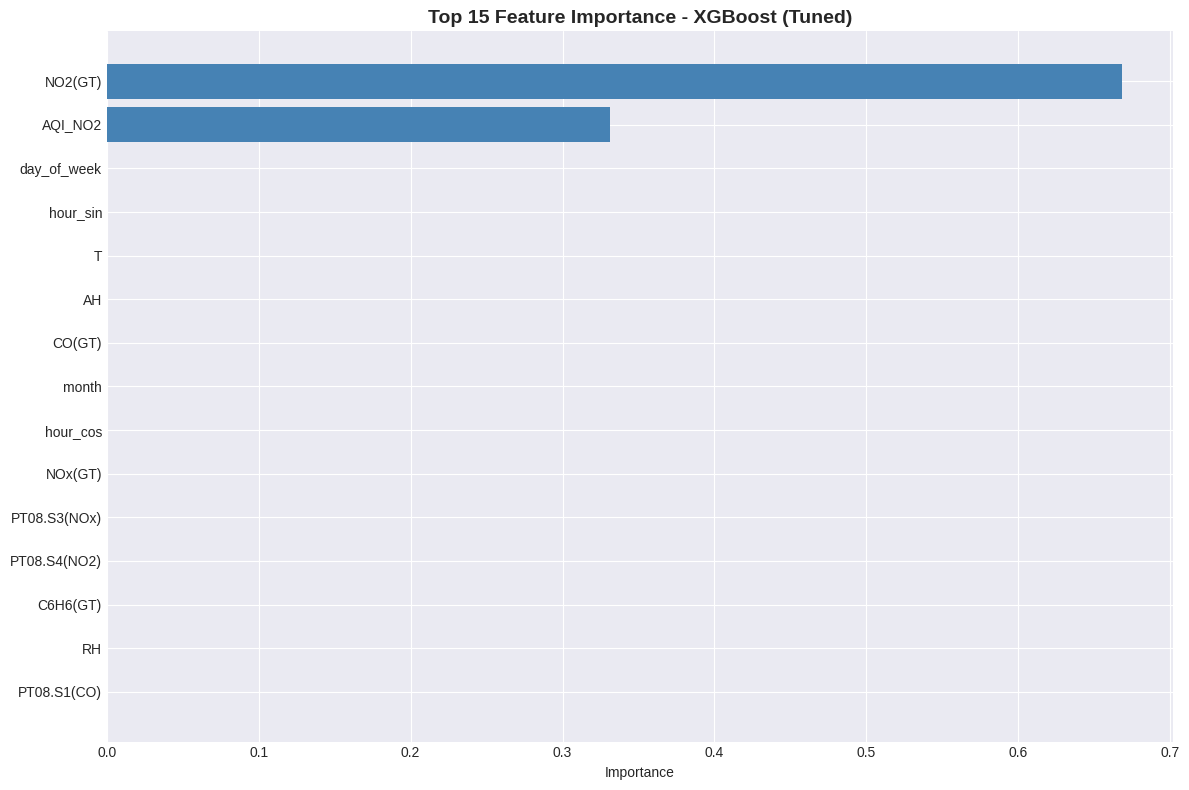

In [41]:
# Get best model (highest R2)
best_model_name = tuned_results_df.iloc[0]['Model']
print(f"\n{'='*80}")
print(f"FEATURE IMPORTANCE - {best_model_name}")
print(f"{'='*80}")

# Get the trained model
if 'Random Forest' in best_model_name:
    best_model = rf_grid.best_estimator_
elif 'XGBoost' in best_model_name:
    best_model = xgb_grid.best_estimator_
elif 'LightGBM' in best_model_name:
    best_model = lgb_grid.best_estimator_
elif 'Gradient Boosting' in best_model_name:
    best_model = gb_grid.best_estimator_

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(15))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'].head(15),
         feature_importance['Importance'].head(15),
         color='steelblue')
plt.xlabel('Importance')
plt.title(f'Top 15 Feature Importance - {best_model_name}', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 11. Prediction Visualization

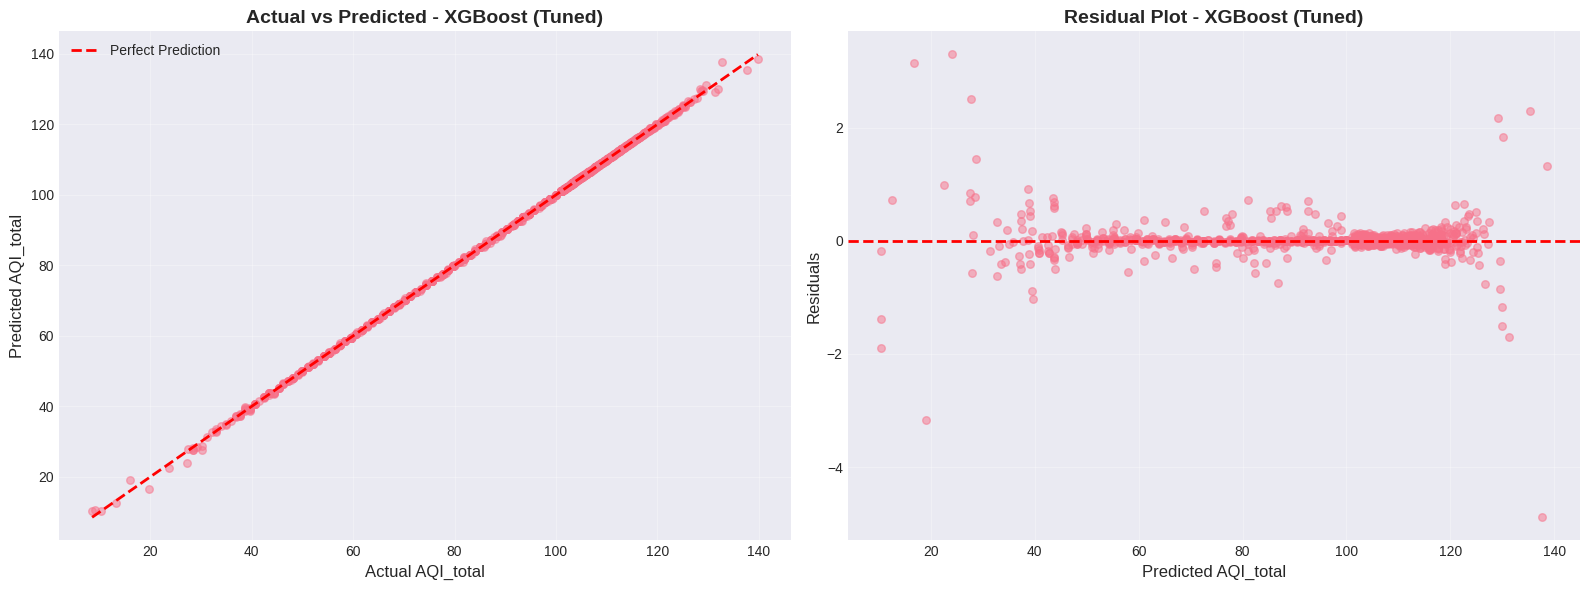

In [42]:
# Predictions on test set
y_pred_final = best_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted
axes[0].scatter(y_test, y_pred_final, alpha=0.5, s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual AQI_total', fontsize=12)
axes[0].set_ylabel('Predicted AQI_total', fontsize=12)
axes[0].set_title(f'Actual vs Predicted - {best_model_name}', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals
residuals = y_test - y_pred_final
axes[1].scatter(y_pred_final, residuals, alpha=0.5, s=30)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted AQI_total', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title(f'Residual Plot - {best_model_name}', fontweight='bold', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 12. Summary and Conclusions

In [46]:
print("\n" + "="*100)
print("FINAL SUMMARY")
print("="*100)

print(f"\nBest Model: {best_model_name}")
print(f"Test R²: {tuned_results_df.iloc[0]['Test R2']:.4f}")
print(f"Test RMSE: {tuned_results_df.iloc[0]['Test RMSE']:.4f}")
print(f"Test MAE: {tuned_results_df.iloc[0]['Test MAE']:.4f}")

print("\nTop 5 Most Important Features:")
print(feature_importance.head(5).to_string(index=False))


FINAL SUMMARY

Best Model: XGBoost (Tuned)
Test R²: 0.9998
Test RMSE: 0.3157
Test MAE: 0.1032

Top 5 Most Important Features:
    Feature  Importance
    NO2(GT)    0.668394
    AQI_NO2    0.331243
day_of_week    0.000055
   hour_sin    0.000045
          T    0.000035


## 13. Overfitting Analysis - Best Model


OVERFITTING ANALYSIS - BEST MODEL

Model: XGBoost (Tuned)

----------------------------------------------------------------------------------------------------
  Metric    Train     Test  Difference  Difference %
R² Score 1.000000 0.999823    0.000177      0.017672
    RMSE 0.008138 0.315687   -0.307549   3779.310823
     MAE 0.005642 0.103226   -0.097583   1729.498278
MAPE (%) 0.006960 0.208756   -0.201796   2899.212796
----------------------------------------------------------------------------------------------------

OVERFITTING ASSESSMENT:
Train R²: 1.0000
Test R²:  0.9998
Difference: 0.0002 (0.02%)

Status: ✅ EXCELLENT - No overfitting


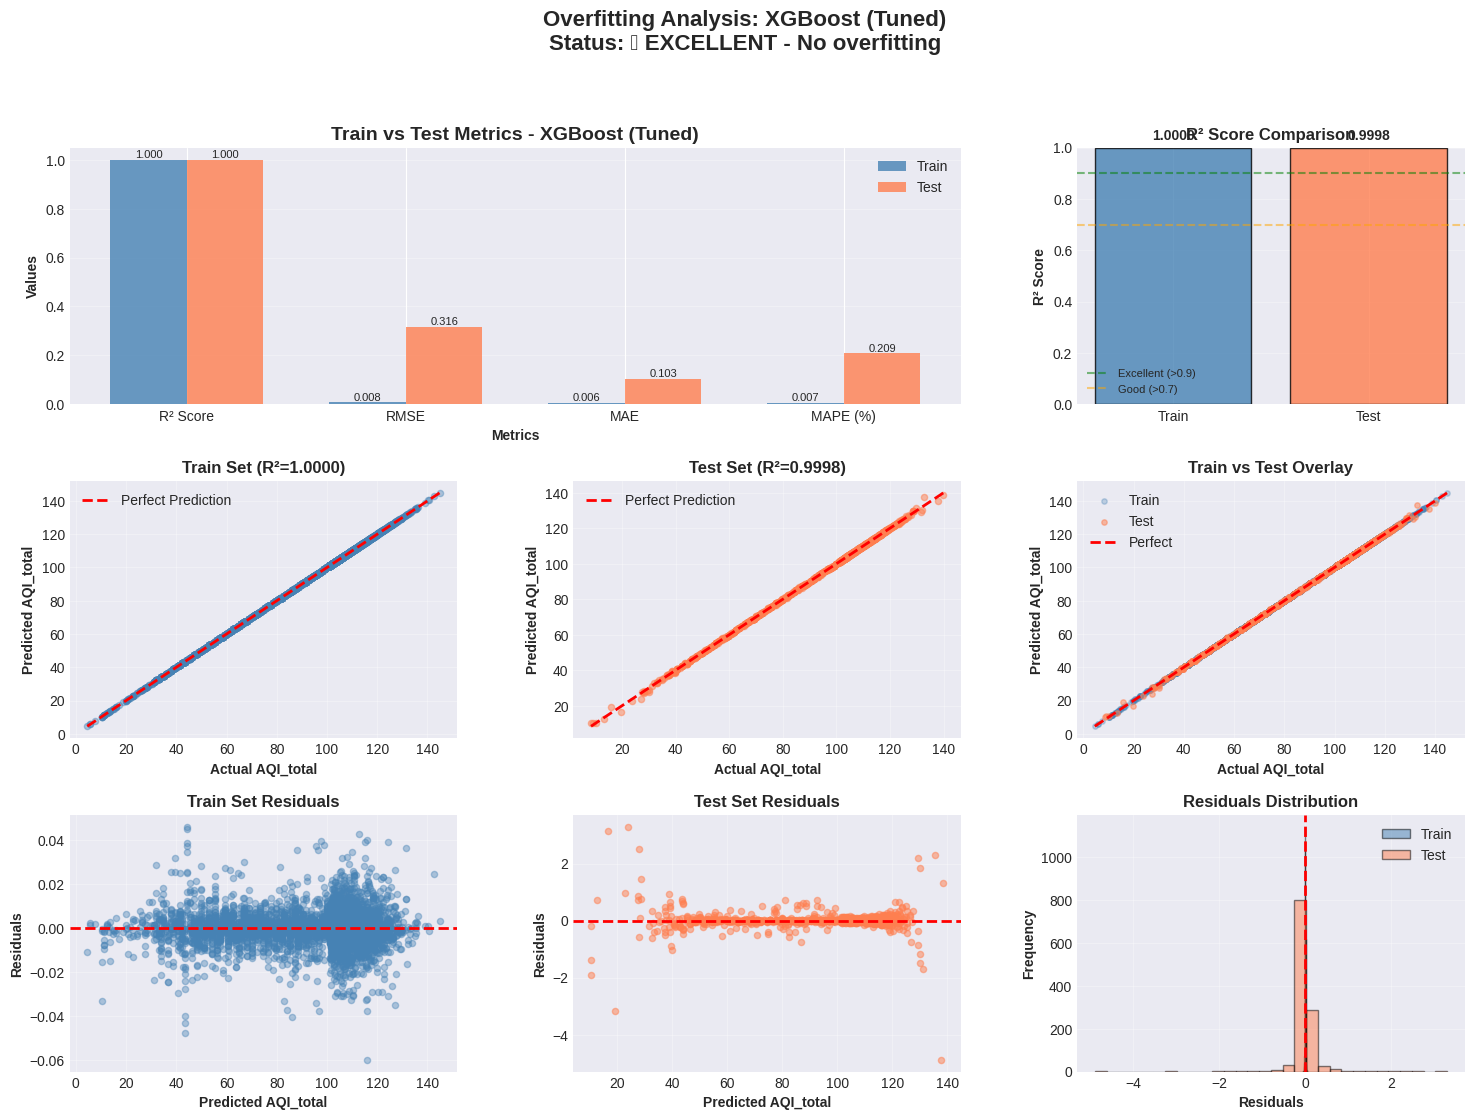


LEARNING CURVE ANALYSIS


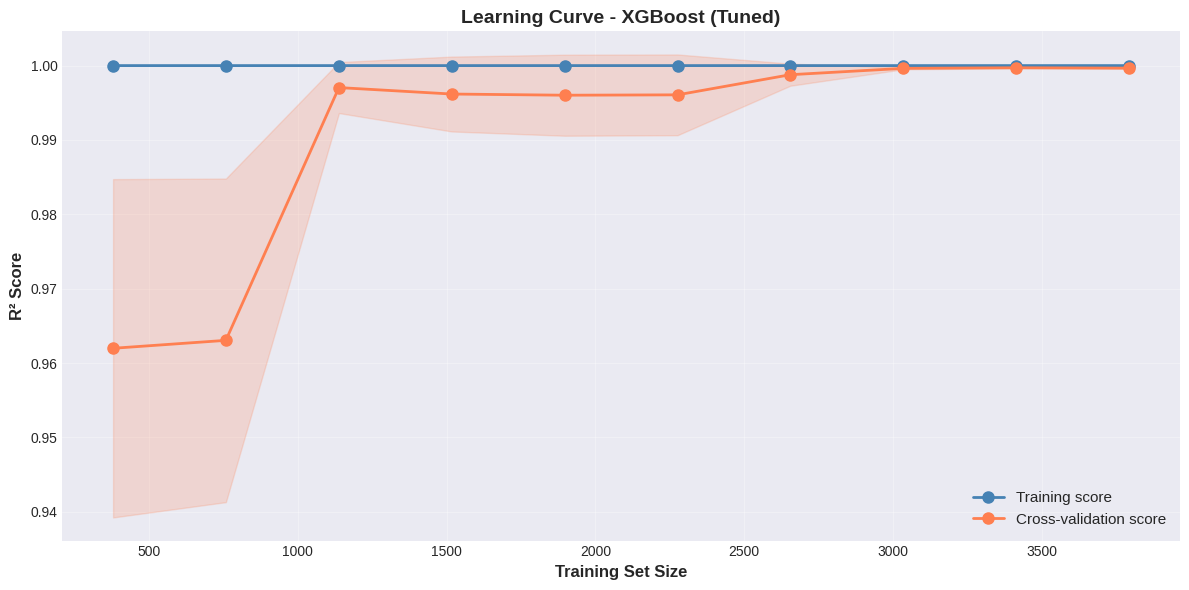


Learning Curve Analysis:
Final Training Score: 1.0000
Final CV Score: 0.9997
Gap: 0.0003
✅ The learning curves have converged well - minimal overfitting



In [47]:
print("\n" + "="*100)
print("OVERFITTING ANALYSIS - BEST MODEL")
print("="*100)

# Get best model from tuning results
best_model_name = tuned_results_df.iloc[0]['Model']
best_test_r2 = tuned_results_df.iloc[0]['Test R2']

# Get the trained model
if 'Random Forest' in best_model_name:
    best_model = rf_grid.best_estimator_
    X_train_use, X_test_use = X_train, X_test
elif 'XGBoost' in best_model_name:
    best_model = xgb_grid.best_estimator_
    X_train_use, X_test_use = X_train, X_test
elif 'LightGBM' in best_model_name:
    best_model = lgb_grid.best_estimator_
    X_train_use, X_test_use = X_train, X_test
elif 'Gradient Boosting' in best_model_name:
    best_model = gb_grid.best_estimator_
    X_train_use, X_test_use = X_train, X_test

# Predictions
y_train_pred = best_model.predict(X_train_use)
y_test_pred = best_model.predict(X_test_use)

# Calculate metrics for both train and test
train_metrics = {
    'R² Score': r2_score(y_train, y_train_pred),
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'MAE': mean_absolute_error(y_train, y_train_pred),
    'MAPE (%)': np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
}

test_metrics = {
    'R² Score': r2_score(y_test, y_test_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'MAE': mean_absolute_error(y_test, y_test_pred),
    'MAPE (%)': np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
}

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': list(train_metrics.keys()),
    'Train': list(train_metrics.values()),
    'Test': list(test_metrics.values())
})
comparison_df['Difference'] = comparison_df['Train'] - comparison_df['Test']
comparison_df['Difference %'] = (comparison_df['Difference'] / comparison_df['Train'] * 100).abs()

print(f"\nModel: {best_model_name}")
print("\n" + "-"*100)
print(comparison_df.to_string(index=False))
print("-"*100)

# Overfitting assessment
r2_diff = train_metrics['R² Score'] - test_metrics['R² Score']
r2_diff_pct = (r2_diff / train_metrics['R² Score']) * 100

print(f"\n{'='*100}")
print("OVERFITTING ASSESSMENT:")
print(f"{'='*100}")
print(f"Train R²: {train_metrics['R² Score']:.4f}")
print(f"Test R²:  {test_metrics['R² Score']:.4f}")
print(f"Difference: {r2_diff:.4f} ({r2_diff_pct:.2f}%)")

if r2_diff < 0.02:
    status = "✅ EXCELLENT - No overfitting"
    color_status = 'green'
elif r2_diff < 0.05:
    status = "✅ GOOD - Minimal overfitting"
    color_status = 'lightgreen'
elif r2_diff < 0.10:
    status = "⚠️  MODERATE - Some overfitting detected"
    color_status = 'orange'
else:
    status = "❌ HIGH - Significant overfitting!"
    color_status = 'red'

print(f"\nStatus: {status}")
print(f"{'='*100}")

# Visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Metrics Comparison Bar Chart
ax1 = fig.add_subplot(gs[0, :2])
x = np.arange(len(comparison_df))
width = 0.35
bars1 = ax1.bar(x - width/2, comparison_df['Train'], width, label='Train', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, comparison_df['Test'], width, label='Test', alpha=0.8, color='coral')
ax1.set_xlabel('Metrics', fontweight='bold')
ax1.set_ylabel('Values', fontweight='bold')
ax1.set_title(f'Train vs Test Metrics - {best_model_name}', fontweight='bold', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Metric'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

# 2. R² Score Comparison with Status
ax2 = fig.add_subplot(gs[0, 2])
r2_scores = [train_metrics['R² Score'], test_metrics['R² Score']]
colors_r2 = ['steelblue', 'coral']
bars = ax2.bar(['Train', 'Test'], r2_scores, color=colors_r2, alpha=0.8, edgecolor='black')
ax2.set_ylabel('R² Score', fontweight='bold')
ax2.set_title('R² Score Comparison', fontweight='bold')
ax2.set_ylim([0, 1])
ax2.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Excellent (>0.9)')
ax2.axhline(y=0.7, color='orange', linestyle='--', alpha=0.5, label='Good (>0.7)')
ax2.legend(fontsize=8)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, score in zip(bars, r2_scores):
    ax2.text(bar.get_x() + bar.get_width()/2., score + 0.02,
            f'{score:.4f}',
            ha='center', va='bottom', fontweight='bold')

# 3. Train Set: Actual vs Predicted
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_train, y_train_pred, alpha=0.4, s=20, color='steelblue')
ax3.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
         'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual AQI_total', fontweight='bold')
ax3.set_ylabel('Predicted AQI_total', fontweight='bold')
ax3.set_title(f'Train Set (R²={train_metrics["R² Score"]:.4f})', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Test Set: Actual vs Predicted
ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(y_test, y_test_pred, alpha=0.5, s=20, color='coral')
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
ax4.set_xlabel('Actual AQI_total', fontweight='bold')
ax4.set_ylabel('Predicted AQI_total', fontweight='bold')
ax4.set_title(f'Test Set (R²={test_metrics["R² Score"]:.4f})', fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Overlay comparison
ax5 = fig.add_subplot(gs[1, 2])
ax5.scatter(y_train, y_train_pred, alpha=0.3, s=15, color='steelblue', label='Train')
ax5.scatter(y_test, y_test_pred, alpha=0.5, s=15, color='coral', label='Test')
ax5.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         'r--', lw=2, label='Perfect')
ax5.set_xlabel('Actual AQI_total', fontweight='bold')
ax5.set_ylabel('Predicted AQI_total', fontweight='bold')
ax5.set_title('Train vs Test Overlay', fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Train Residuals
ax6 = fig.add_subplot(gs[2, 0])
train_residuals = y_train - y_train_pred
ax6.scatter(y_train_pred, train_residuals, alpha=0.4, s=20, color='steelblue')
ax6.axhline(y=0, color='r', linestyle='--', lw=2)
ax6.set_xlabel('Predicted AQI_total', fontweight='bold')
ax6.set_ylabel('Residuals', fontweight='bold')
ax6.set_title('Train Set Residuals', fontweight='bold')
ax6.grid(alpha=0.3)

# 7. Test Residuals
ax7 = fig.add_subplot(gs[2, 1])
test_residuals = y_test - y_test_pred
ax7.scatter(y_test_pred, test_residuals, alpha=0.5, s=20, color='coral')
ax7.axhline(y=0, color='r', linestyle='--', lw=2)
ax7.set_xlabel('Predicted AQI_total', fontweight='bold')
ax7.set_ylabel('Residuals', fontweight='bold')
ax7.set_title('Test Set Residuals', fontweight='bold')
ax7.grid(alpha=0.3)

# 8. Residuals Distribution Comparison
ax8 = fig.add_subplot(gs[2, 2])
ax8.hist(train_residuals, bins=30, alpha=0.5, label='Train', color='steelblue', edgecolor='black')
ax8.hist(test_residuals, bins=30, alpha=0.5, label='Test', color='coral', edgecolor='black')
ax8.axvline(x=0, color='r', linestyle='--', lw=2)
ax8.set_xlabel('Residuals', fontweight='bold')
ax8.set_ylabel('Frequency', fontweight='bold')
ax8.set_title('Residuals Distribution', fontweight='bold')
ax8.legend()
ax8.grid(alpha=0.3)

plt.suptitle(f'Overfitting Analysis: {best_model_name}\nStatus: {status}',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Learning Curve (if not too computationally expensive)
print("\n" + "="*100)
print("LEARNING CURVE ANALYSIS")
print("="*100)

from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes_abs, train_scores, test_scores = learning_curve(
    best_model, X_train_use, y_train,
    train_sizes=train_sizes, cv=5,
    scoring='r2', n_jobs=-1, random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='steelblue',
         label='Training score', linewidth=2, markersize=8)
plt.fill_between(train_sizes_abs,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.2, color='steelblue')

plt.plot(train_sizes_abs, test_scores_mean, 'o-', color='coral',
         label='Cross-validation score', linewidth=2, markersize=8)
plt.fill_between(train_sizes_abs,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color='coral')

plt.xlabel('Training Set Size', fontweight='bold', fontsize=12)
plt.ylabel('R² Score', fontweight='bold', fontsize=12)
plt.title(f'Learning Curve - {best_model_name}', fontweight='bold', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretation
gap = train_scores_mean[-1] - test_scores_mean[-1]
print(f"\nLearning Curve Analysis:")
print(f"Final Training Score: {train_scores_mean[-1]:.4f}")
print(f"Final CV Score: {test_scores_mean[-1]:.4f}")
print(f"Gap: {gap:.4f}")

if gap < 0.05:
    print("✅ The learning curves have converged well - minimal overfitting")
elif gap < 0.10:
    print("⚠️  Moderate gap between train and CV scores - some overfitting")
else:
    print("❌ Large gap - model is overfitting")

if test_scores_mean[-1] < 0.7:
    print("⚠️  CV score is relatively low - consider:")
    print("   - Adding more features")
    print("   - Increasing model complexity")
    print("   - Collecting more data")

print("\n" + "="*100)

In [48]:
import pickle
import os

# Get the best model from the tuning results
best_model_name = tuned_results_df.iloc[0]['Model']

# Retrieve the actual trained model object
if 'Random Forest' in best_model_name:
    best_model = rf_grid.best_estimator_
elif 'XGBoost' in best_model_name:
    best_model = xgb_grid.best_estimator_
elif 'LightGBM' in best_model_name:
    best_model = lgb_grid.best_estimator_
elif 'Gradient Boosting' in best_model_name:
    best_model = gb_grid.best_estimator_
else:
    best_model = None
    print(f"Warning: Could not find the trained model object for {best_model_name}")


if best_model:
    # Define the filename with .pkl extension
    model_filename = f"{best_model_name.replace(' ', '_').replace('(', '').replace(')', '')}_model.pkl"

    # Save the model using pickle
    with open(model_filename, 'wb') as f:
        pickle.dump(best_model, f)

    print(f"Model saved successfully as '{model_filename}'")
    print(f"You can download the model file from the files section.")

    # Provide a link to download the file in Colab (optional, but helpful)
    # from google.colab import files
    # files.download(model_filename)

else:
    print("Model object not found, cannot save.")

Model saved successfully as 'XGBoost_Tuned_model.pkl'
You can download the model file from the files section.
